# Converge Parameters
We want to find the minimum cutoff energy and buffer around the molecule.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from fff.simulation.utils import read_from_string
from ase.calculators.cp2k import CP2K
from tempfile import TemporaryDirectory
from contextlib import redirect_stderr
from time import perf_counter
from zipfile import ZipFile
from pathlib import Path
from ase.io import read
from ase import units
from io import StringIO
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import json
import os

Configuration

In [2]:
basis_set = 'DZVP-MOLOPT-SR-GTH'
file_ind = 1
results_file = Path('convergence-results.json')

## Get Example MOFs
We'll test on something with our atom that has the most valence electrons, S.

In [3]:
qmof = ZipFile('../data/qmof_database/relaxed_structures.zip')

In [4]:
file = qmof.filelist[file_ind]
file

<ZipInfo filename='relaxed_structures/qmof-00019ff.cif' compress_type=deflate external_attr=0x20 file_size=8683 compress_size=3303>

In [5]:
atoms = read_from_string(qmof.read(file).decode(), 'cif')
atoms

Atoms(symbols='C36H28Br4CoN8O4', pbc=True, cell=[[8.86655306, 0.0, 0.0], [-0.027991297179981302, 9.639833900758996, 0.0], [-3.1373625087379553, -4.080310739130243, 10.60319827175915]], spacegroup_kinds=...)

CP2K requires us to define a cell even for non-periodic systems

## Evalute the effect of convergence of buffer size and cutoff
These should be all we need to converge

In [6]:
shutil.rmtree('conv', ignore_errors=True)

In [7]:
cp2k_opts = dict(
    inp="""&FORCE_EVAL
&DFT
  &XC
     &XC_FUNCTIONAL PBE
     &END XC_FUNCTIONAL
     &vdW_POTENTIAL
        DISPERSION_FUNCTIONAL PAIR_POTENTIAL
        &PAIR_POTENTIAL
            TYPE DFTD3(BJ)
            PARAMETER_FILE_NAME dftd3.dat
            REFERENCE_FUNCTIONAL PBE
        &END PAIR_POTENTIAL
    &END vdW_POTENTIAL
  &END XC
  &SCF
    MAX_DIIS  8
    EPS_SCF  1.0E-06
    &OT
      MINIMIZER  CG
      PRECONDITIONER  FULL_SINGLE_INVERSE
    &END OT
    &OUTER_SCF  T
      MAX_SCF  25
      EPS_SCF  1.0E-06
    &END OUTER_SCF
  &END SCF
  &MGRID
    ! CUTOFF 600
    REL_CUTOFF [Ry] 60.0
    COMMENSURATE TRUE
    NGRIDS 5
  &END MGRID
&END DFT
&END FORCE_EVAL""",
    basis_set_file='BASIS_MOLOPT',
    basis_set=basis_set,
    pseudo_potential='GTH-PBE',
)  # Use BLYP as we have PPs for it
calc = CP2K(directory='conv', uks=True, xc=None,
            print_level='medium',
            command='/home/lward/Software/cp2k-2022.2/exe/local_cuda/cp2k_shell.ssmp',
            **cp2k_opts)

In [8]:
cutoffs = np.arange(400, 1200.1, 100)
print(f'Testing {len(cutoffs)} energies')

Testing 9 energies


Test many cutoff energies

In [9]:
previous = {}  # (file_ind, basis, cutoff) -> {'energy': ..., 'forces': ...}
if results_file.is_file():
    with results_file.open() as fp:
        for l in fp:
            record = json.loads(l)
            previous[(record.pop('file_ind'), record.pop('basis'), record.pop('cutoff'))] = record

In [10]:
forces = []
energy = []
for cutoff in tqdm(cutoffs):
    if (result := previous.get((file_ind, basis_set, cutoff), None)) is None:
        # Run if it isn't done yet
        calc.set(cutoff=cutoff * units.Ry)
        start_time = perf_counter()
        my_forces = calc.get_forces(atoms)
        my_energy = calc.get_potential_energy(atoms)
        my_stress = calc.get_stress(atoms)
        run_time = perf_counter() - start_time
        
        # Write to disk
        with results_file.open('a') as fp:
            print(json.dumps({
                'file_ind': file_ind,
                'basis': basis_set,
                'cutoff': cutoff,
                'energy': my_energy,
                'forces': my_forces.tolist(),
                'stress': my_stress.tolist(),
                'num_atoms': len(atoms),
                'runtime': run_time,
            }), file=fp)
    else:
        my_forces = np.array(result['forces'])
        my_energy = result['energy']
        
    forces.append(my_forces)
    energy.append(my_energy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24883.81it/s]


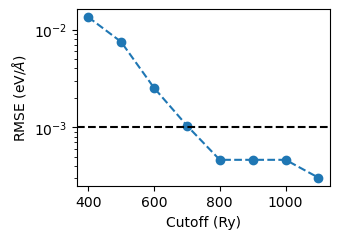

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

rmse = [np.sqrt(np.power(f - forces[-1], 2).mean()) for f in forces]
ax.semilogy(cutoffs[:-1], rmse[:-1], '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0.001] * 2, 'k--')

ax.set_xlabel('Cutoff (Ry)')
ax.set_ylabel('RMSE (eV/$\\AA$)')
fig.tight_layout()

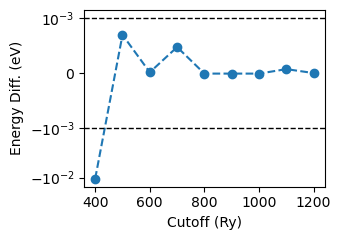

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(cutoffs, np.subtract(energy, energy[-1]), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-3)

ax.set_xlabel('Cutoff (Ry)')
ax.set_ylabel('Energy Diff. (eV)')
fig.tight_layout()

Results from a few different tests. The goal is to converge forces within 0.001 meV/A

| MOF v, Basis > | SZV | DZVP | 
|----------------|-----|------|
| 0 (Cu2H24C14N4O6) |     | <700 |
| 1 (C36H28Br4CoN8O4) | | 700 |
| *Maximum*      |     | 1000  |

TODO:
- Convert the REL_CUTOFF. I just picked a "large value" and what was used in [this paper](https://www.nature.com/articles/s41524-023-00969-x)
- Use TZVP basis set (as in [this paper](https://www.nature.com/articles/s41524-023-00969-x)), which will require using basis sets from different files